In [6]:
from pathlib import Path

from cities.utils.data_grabber import DataGrabber
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pickle
import os
import sys


current_dir =  os.getcwd()

grandparent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, grandparent_dir)

In [106]:
data = DataGrabber()
data.get_features_wide(["gdp", "population", "spending_HHS"])
gdp = data.wide
gdp = gdp.get("gdp")


population= data.wide
population = population.get("population")

spending_HHS= data.wide
spending_HHS = spending_HHS.get("spending_HHS")

In [220]:
def standardize_and_scale(data: pd.DataFrame, variable_name: str) -> pd.DataFrame:
  
    transformation_info_dict_path = f"{grandparent_dir}/data/raw/std_info.pkl"
    if os.path.exists(transformation_info_dict_path):
        with open(transformation_info_dict_path, "rb") as file:
            transformation_info_dict = pickle.load(file)
    else:
        transformation_info_dict = {}
    
    standard_scaler = StandardScaler()  # Standardize to mean 0, std 1

    def sigmoid(x, scale=1 / 4):
        return 2 / (1 + np.exp(-x * scale)) - 1


    new_data = data.copy()


    float_cols = data.select_dtypes(include=["float64"])


    transformation_info = {}

    for column in float_cols.columns:
        # Get mean and std for each column
        mean_value = float_cols[column].mean()
        std_value = float_cols[column].std()

        # Save information in the dictionary
        transformation_info[column] = {"mean": mean_value, "std": std_value}

        # Standardize float columns to mean 0, std 1
        standardized_values = standard_scaler.fit_transform(float_cols[[column]])

        # Apply sigmoid transformation, [-3std, 3std] to [-1, 1]
        new_data[column] = sigmoid(standardized_values, scale=1 / 4)

    # Update the global transformation_info_dict
    transformation_info_dict[variable_name] = transformation_info

    with open(f"{grandparent_dir}/data/raw/std_info.pkl", "wb") as file:
        pickle.dump(transformation_info_dict, file)


    return new_data


def revert_standardize_and_scale(data: pd.DataFrame, variable_name: str) -> pd.DataFrame:
    """
    Inverts the standardization and scaling operation using the provided transformation information from a file.
    Returns the original DataFrame.
    """
    def inverse_sigmoid(y, scale=1 / 4):
        return -np.log((2 / (y + 1)) - 1) / scale


    inverted_data = data.copy()


    file_path = f"{grandparent_dir}/data/raw/std_info.pkl"
    with open(file_path, "rb") as file:
        transformation_info_dict = pickle.load(file)

    transformation_info = transformation_info_dict.get(variable_name, {})

    

    for column, info in transformation_info.items():

        inverted_values = inverse_sigmoid(data[column])


        inverted_values = inverted_values * info["std"] + info["mean"]

        # mitigating the influence of negative values
        inverted_values[inverted_values < 0] = inverted_values * -0.0000001

        inverted_data[column] = inverted_values

    return inverted_data

In [119]:
gdp

,GeoFIPS,GeoName,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",59.839,61.996,63.508,73.730,75.307,80.459,81.836,73.870,...,86.679,93.060,93.155,99.931,104.090,99.798,100.854,97.233,96.115,94.638
1,1003,"Baldwin, AL",73.853,77.273,81.570,90.523,101.402,104.553,107.840,102.635,...,99.000,104.651,106.431,110.434,115.476,118.498,125.068,131.431,131.614,144.294
2,1005,"Barbour, AL",113.864,111.853,114.628,124.473,125.004,122.611,118.397,110.695,...,103.918,113.335,106.760,103.702,101.969,100.509,101.804,102.053,98.044,99.393
3,1007,"Bibb, AL",80.443,81.527,85.124,89.317,88.782,89.597,95.308,94.745,...,102.559,99.537,97.933,94.594,95.812,96.878,96.988,104.620,109.487,107.878
4,1009,"Blount, AL",92.104,92.593,95.469,98.129,100.918,97.428,96.720,97.077,...,91.938,99.318,101.584,106.506,98.394,104.331,109.560,106.565,100.422,113.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",92.340,81.094,83.237,84.315,89.539,103.241,109.911,112.520,...,103.317,99.506,96.656,93.916,91.543,89.449,86.267,88.195,80.164,74.912
3070,56039,"Teton, WY",81.931,84.886,85.316,86.359,88.884,96.508,98.646,97.627,...,95.810,102.194,110.461,112.837,114.846,119.415,121.268,123.476,125.412,155.522
3071,56041,"Uinta, WY",99.906,110.550,107.053,108.929,112.808,123.552,126.916,127.784,...,106.181,96.674,94.344,95.302,94.681,93.024,89.431,86.759,77.512,76.147
3072,56043,"Washakie, WY",92.187,91.281,95.083,95.411,91.317,102.153,95.987,106.530,...,107.934,101.335,104.043,106.056,94.451,89.130,89.160,92.316,91.539,92.003


In [114]:
gdp_stand = standardize_and_scale(gdp, "gdp")
gdp_restored = revert_standardize_and_scale(gdp_stand, "gdp")

gdp_restored


,GeoFIPS,GeoName,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",59.834763,61.991753,63.503627,73.726927,75.303761,80.456395,81.833542,73.866173,...,86.676848,93.058381,93.153106,99.929887,104.089509,99.796658,100.852571,97.230688,96.112770,94.635037
1,1003,"Baldwin, AL",73.851043,77.271238,81.568565,90.522659,101.403006,104.554315,107.841773,102.635853,...,98.999852,104.651267,106.431266,110.434595,115.477361,118.499701,125.070510,131.434252,131.617546,144.299116
2,1005,"Barbour, AL",113.868552,111.856864,114.631944,124.478183,125.008846,122.615253,118.400491,110.697164,...,103.918652,113.336680,106.760319,103.701500,101.968164,100.507774,101.802725,102.051472,98.042084,99.390811
3,1007,"Bibb, AL",80.442115,81.525931,85.123144,89.316463,88.780953,89.595882,95.307734,94.744569,...,102.559431,99.536435,97.931883,94.592018,95.810162,96.876183,96.985942,104.618890,109.486946,107.877191
4,1009,"Blount, AL",92.105012,92.593731,95.469827,98.129897,100.918928,97.428156,96.719964,97.076949,...,91.936703,99.317400,101.583477,106.505956,98.392582,104.330396,109.559987,106.564206,100.420471,113.455099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",92.341050,81.092860,83.235837,84.313649,89.538076,103.242102,109.913110,112.522461,...,103.317555,99.505430,96.654675,93.913908,91.540467,89.445975,86.263197,88.191217,80.159175,74.905828
3070,56039,"Teton, WY",81.930357,84.885477,85.315175,86.357982,88.882970,96.508006,98.646277,97.627038,...,95.809333,102.193868,110.461921,112.837986,114.847259,119.416850,121.269892,123.477957,125.414537,155.528943
3071,56041,"Uinta, WY",99.908281,110.553652,107.055711,108.931654,112.810862,123.556406,126.920877,127.788945,...,106.182021,96.672969,94.342299,95.300134,94.678978,93.021556,89.427712,86.754984,77.506744,76.141029
3072,56043,"Washakie, WY",92.188026,91.281517,95.083764,95.411455,91.316366,102.153925,95.986845,106.531487,...,107.935306,101.334728,104.042877,106.055883,94.448941,89.126923,89.156668,92.312888,91.536026,91.999609


In [228]:
def compare_restored_data(data_oryg: pd.DataFrame, data_restored: pd.DataFrame) -> None:
    

    oryg_values = data_oryg.select_dtypes(include=["float64"]).values.flatten()
    restored_values = data_restored.select_dtypes(include=["float64"]).values.flatten()



    differences = abs(oryg_values - restored_values)


    df = pd.DataFrame({'original': oryg_values, 'diff': differences})

   
    df['percentages'] = (df['diff'] / df['original'] + 0.0000001) * 100

    df = df.sort_values(by='original', ascending=True)


    plt.figure(figsize=(10, 6))
    plt.plot(df['original'], df['percentages'], marker='o', linestyle='-')

    plt.title('Differences between original and restored data')
    plt.xlabel('Index')
    plt.ylabel('Percentage Difference')

    return plt.show()


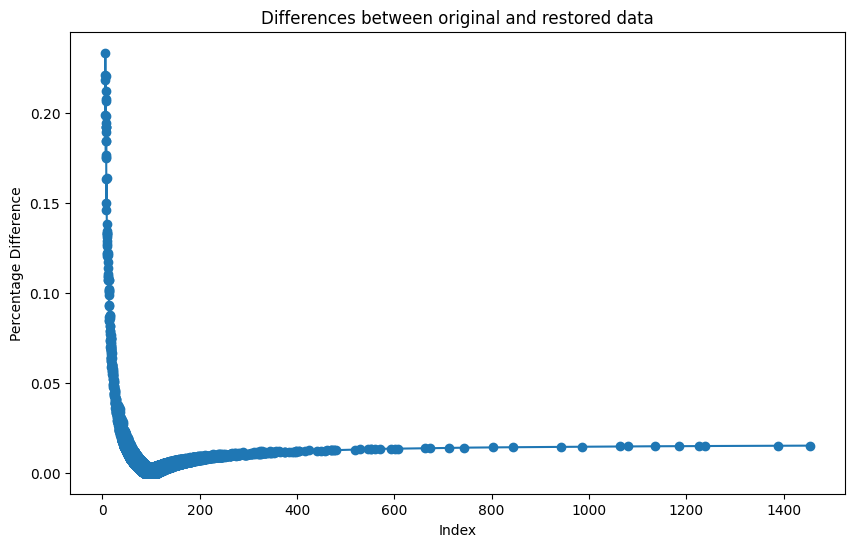

In [229]:
compare_restored_data(gdp, gdp_restored)

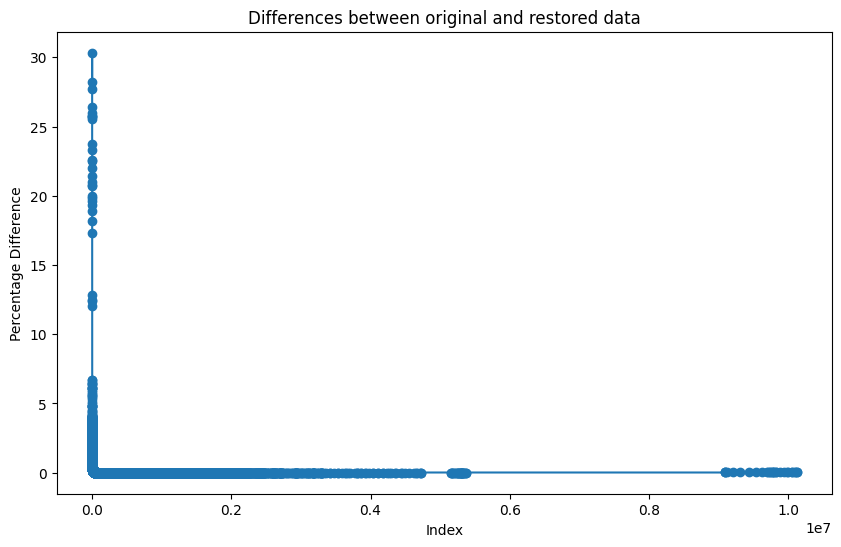

In [225]:
population_stand = standardize_and_scale(population, "population")
population_restored = revert_standardize_and_scale(population_stand, "population")
compare_restored_data(population, population_restored)

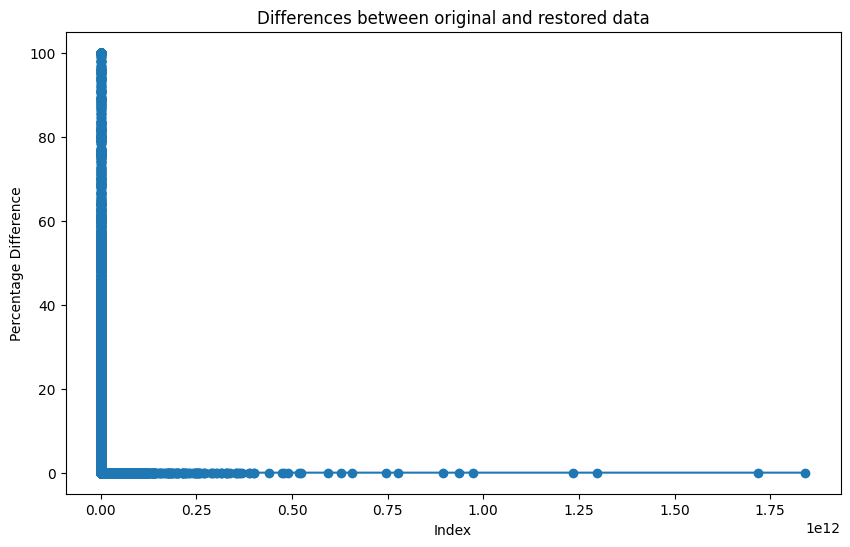

In [226]:
spending_HHS_stand = standardize_and_scale(spending_HHS, "spending_HHS")
spending_HHS_restored = revert_standardize_and_scale(spending_HHS_stand, "spending_HHS")
compare_restored_data(spending_HHS, spending_HHS_restored)

In [231]:
with open(f"{grandparent_dir}/data/raw/std_info.pkl", "rb") as file:
    loaded_data = pickle.load(file)

loaded_data.keys()

dict_keys(['spending_HHS', 'gdp', 'population'])